In [63]:
# !pip install numpy pandas pandas_ta matplotlib yfinance keras tensorflow

In [64]:
# Importing libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import pandas_ta as ta

# Importing libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Importing sklearn stuff
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# Importing libraries for fetching financial data
import yfinance as yf

# Importing libraries for deep learning with Keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from tensorflow.keras.models import load_model

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History, EarlyStopping
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

# Importing additional libraries
import datetime
import math


In [65]:
ROOT='./kaggle/input/dt23-test/series'

def csv_to_df_handler(path):
    out_df = pd.read_csv(ROOT+path,index_col='timestamp')
    out_df.index = pd.to_datetime(out_df.index)
    out_df = out_df.sort_index(ascending=True).replace([np.inf, -np.inf], np.nan).interpolate(method='linear').fillna(0)
    return out_df

In [66]:


def fetch_data_from_yfinance_handler(symbol):
    df = yf.download(tickers=symbol, start='2000-01-01').interpolate(method='linear')
    return df


In [67]:
SPY_df = fetch_data_from_yfinance_handler('SPY')
# SPY_df.head()

ISRG_df = fetch_data_from_yfinance_handler('ISRG')
ISRG_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-06-16,2.013889,2.055556,2.000000,2.027778,2.027778,521550
2000-06-19,2.027778,2.055556,2.000000,2.000000,2.000000,1363050
2000-06-20,2.006944,2.180556,1.750000,2.083333,2.083333,1177650
2000-06-21,2.222222,2.472222,2.138889,2.444444,2.444444,2342250
2000-06-22,2.458333,2.472222,2.118056,2.194444,2.194444,857700


In [68]:
ISRG_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-30,260.079987,261.149994,254.850006,258.489990,258.489990,2277800
2023-10-31,260.390015,263.950012,260.170013,262.220001,262.220001,2373300
2023-11-01,262.170013,272.179993,262.000000,270.459991,270.459991,2087300
2023-11-02,274.570007,278.149994,272.630005,277.890015,277.890015,1965800
2023-11-03,280.220001,281.579987,277.390015,278.519989,278.519989,1310500


In [69]:
help(ta.bop)

Help on function bop in module pandas_ta.momentum.bop:

bop(open_, high, low, close, scalar=None, talib=None, offset=None, **kwargs)
    Balance of Power (BOP)
    
    Balance of Power measure the market strength of buyers against sellers.
    
    Sources:
        http://www.worden.com/TeleChartHelp/Content/Indicators/Balance_of_Power.htm
    
    Calculation:
        BOP = scalar * (close - open) / (high - low)
    
    Args:
        open (pd.Series): Series of 'open's
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        scalar (float): How much to magnify. Default: 1
        talib (bool): If TA Lib is installed and talib is True, Returns the TA Lib
            version. Default: True
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        fillna (value, optional): pd.DataFrame.fillna(value)
        fill_method (value, optional): Type of fill method
    
   

In [70]:


def add_indicators(data):
    # Trend Indicators
    data['EMA12'] = ta.ema(data['Adj Close'], length=12)
    data['EMA25'] = ta.ema(data['Adj Close'], length=25)
    data['EMA50'] = ta.ema(data['Adj Close'], length=50)
    data['EMA100'] = ta.ema(data['Adj Close'], length=100)
    data['EMA200'] = ta.ema(data['Adj Close'], length=200)
    data['BOP'] = ta.bop(open_= data['Open'], high=data['High'], low=data['Low'], close=data['Adj Close'])

    # ADX Indicator
    adx_values = ta.adx(high=data['High'], low=data['Low'], close=data['Adj Close'])
    data['ADX'] = adx_values['ADX_14']
    data['+DI'] = adx_values['DMP_14']
    data['-DI'] = adx_values['DMN_14']

    # Momentum Indicators
    data['RSI'] = ta.rsi(data['Adj Close'], length=15)
    
    # Stochastic Oscillator
    stoch_values = ta.stoch(high=data['High'], low=data['Low'], close=data['Adj Close'])
    data['STOCH_K'] = stoch_values['STOCHk_14_3_3']  # Stochastic %K line
    data['STOCH_D'] = stoch_values['STOCHd_14_3_3']  # Stochastic %D line

    # Volume Indicator
    data['OBV'] = ta.obv(close=data['Adj Close'], volume=data['Volume'])

    # Volatility Indicator
    data['ZSCORE'] = ta.zscore(close=data['Adj Close'])
    bbands = ta.bbands(close=data['Adj Close'], length=20, std=2, mamode='sma')
    # print(bbands.columns)  # Print to check the column names

    # Update the DataFrame with the correct column names
    # Replace 'BB_LOWER', 'BB_MIDDLE', 'BB_UPPER' with actual column names from bbands.columns
    data['BB_LOWER'] = bbands['BBL_20_2.0']  # Update with the actual column name for lower band
    data['BB_MIDDLE'] = bbands['BBM_20_2.0']   # Update with the actual column name for middle band
    data['BB_UPPER'] = bbands['BBU_20_2.0']  # Update with the actual column name for upper band
     # MACD (also a momentum indicator)
    macd = ta.macd(data['Adj Close'], fast=12, slow=26, signal=9)
    data['MACD'] = macd['MACD_12_26_9']
    data['MACD_Signal'] = macd['MACDs_12_26_9']
    data['MACD_Hist'] = macd['MACDh_12_26_9']

    # Performance Indicators
    data['proportional_variation_compared_to_previous_day'] = ta.percent_return(data['Adj Close'], cumulative=False)
    data['proportional_variation_compared_to_start'] = ta.percent_return(data['Adj Close'], cumulative=True)

    # Target and Classification
    #target value is the percentage variation of tomorrow compared to today
    data['Target'] = data['proportional_variation_compared_to_previous_day'].shift(-1)
    data.fillna(0, inplace=True)

    return data

In [71]:
SPY_df = add_indicators(SPY_df)
SPY_df.head()

,Open,High,Low,Close,Adj Close,Volume,proportional_variation_compared_to_previous_day,proportional_variation_compared_to_start,Target
Date,,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,94.262581,8164300,0.000000,0.000000,-0.039106
2000-01-04,143.53125,144.06250,139.640625,139.7500,90.576317,8089800,-0.039106,-0.039106,0.001789
2000-01-05,139.93750,141.53125,137.250000,140.0000,90.738350,12177900,0.001789,-0.037387,-0.016071
2000-01-06,139.62500,141.50000,137.750000,137.7500,89.280052,6227200,-0.016071,-0.052858,0.058076
2000-01-07,140.31250,145.75000,140.062500,145.7500,94.465103,8066500,0.058076,0.002148,0.003431


## A glance at correlation and variance


In [72]:
def corr_heatmap(df):
    # Reset the index to remove it from the correlation calculation
    df_reset_index = df.reset_index(drop=True)
    
    graph_size = (12, 12)
    fig, ax = plt.subplots(figsize=graph_size)
    sns.heatmap(df_reset_index.corr(), ax=ax, vmin=-1, vmax=1, cmap='coolwarm')
    plt.show()


In [73]:
SPY_df.var()

Open                                               1.080806e+04
High                                               1.092042e+04
Low                                                1.068736e+04
Close                                              1.081285e+04
Adj Close                                          1.253578e+04
Volume                                             8.545323e+15
proportional_variation_compared_to_previous_day    1.534987e-04
proportional_variation_compared_to_start           1.410823e+00
Target                                             1.534987e-04
dtype: float64

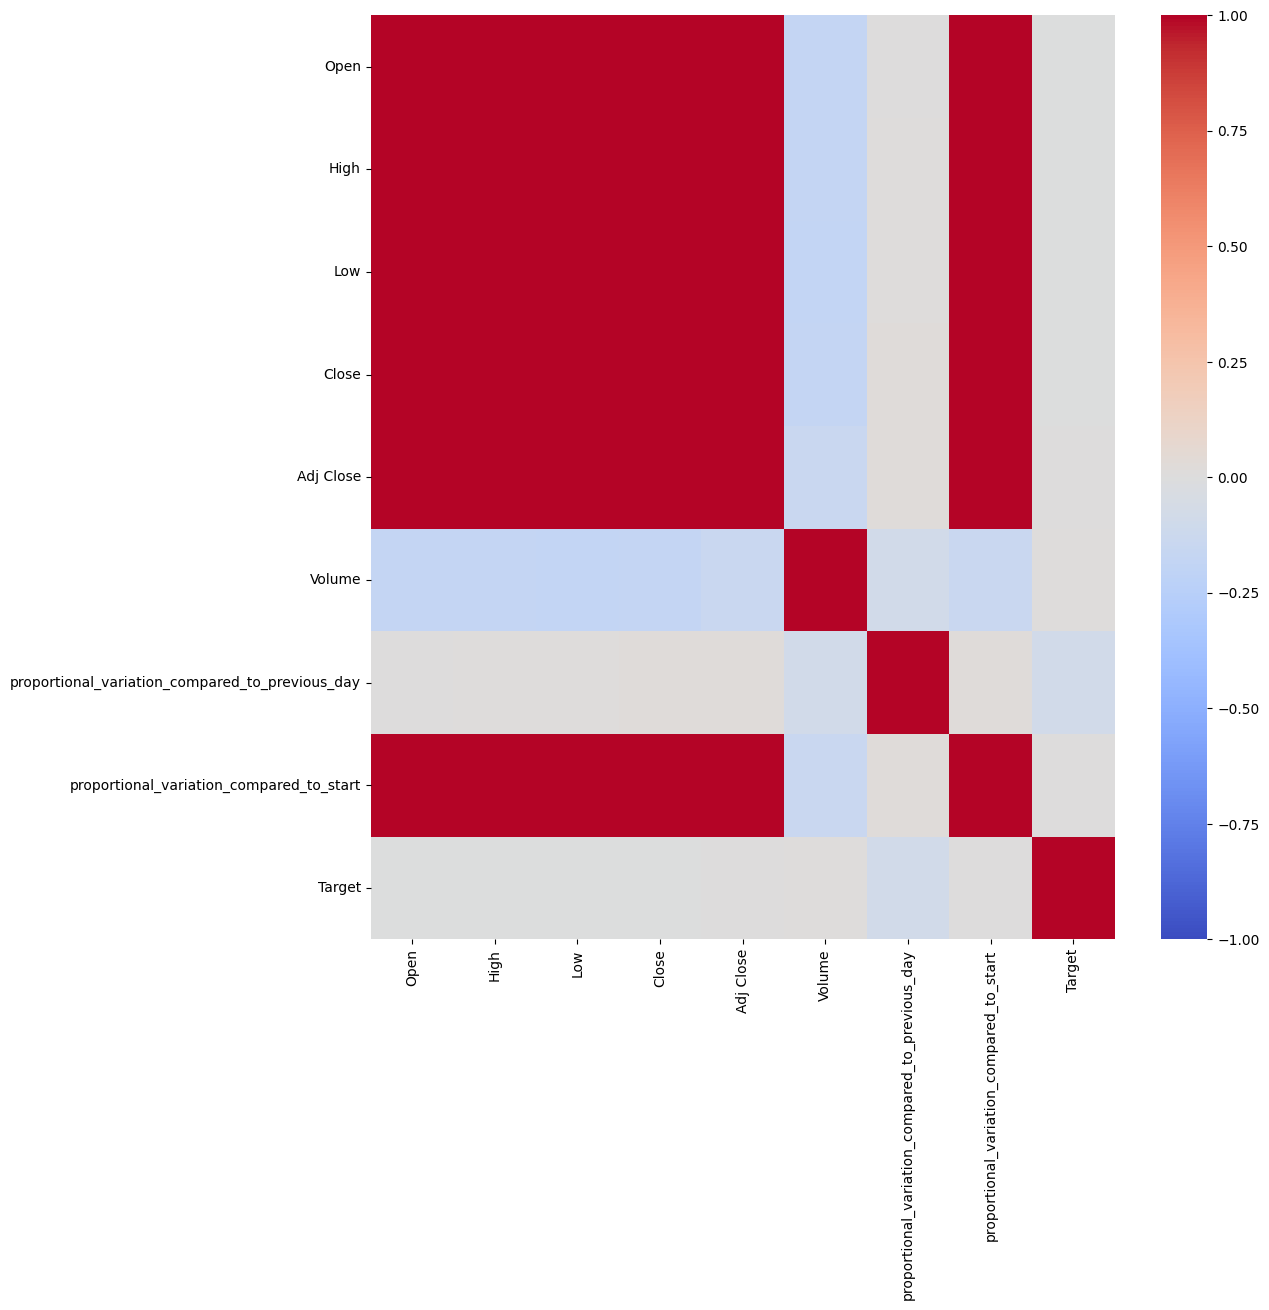

In [74]:
corr_heatmap(SPY_df)

## ML pipeline functions

In [75]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import math

# Scaler for data normalization
sc = MinMaxScaler(feature_range=(0,1))

def refit_data_for_ml(df, backcandles):
    # Drop specified columns, fill missing values, reset index
    df = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'proportional_variation_compared_to_start'], axis=1).fillna(0).reset_index(drop=True)
    df = sc.fit_transform(df)

    # Generate sequences for LSTM
    X = []
    input_cols_num = df.shape[1] - 1
    for j in range(input_cols_num):
        X.append([df[i-backcandles:i, j] for i in range(backcandles, df.shape[0])])

    # Rearrange array dimensions
    X = np.moveaxis(X, 0, 2)
    X, y = np.array(X), np.array(df[backcandles:, -1])
    y = np.reshape(y, (len(y), 1))

    return X, y, sc

def split_ml_dataset(X, y):
    splitlimit = int(len(X) * 0.8)
    X_train, X_test = X[:splitlimit], X[splitlimit:]
    y_train, y_test = y[:splitlimit], y[splitlimit:]

    return X_train, X_test, y_train, y_test

def create_model(num_features, backcandles):
    np.random.seed(10)
    lstm_input = Input(shape=(num_features, backcandles), name='lstm_input')
    lstm_layer = LSTM(150, name='first_layer')(lstm_input)
    dense_layer = Dense(1, name='dense_layer')(lstm_layer)
    output = Activation('linear', name='output')(dense_layer)

    model = Model(inputs=lstm_input, outputs=output)
    return model

def train_model(model, X_train, y_train):
    adam = tf.keras.optimizers.legacy.Adam()
    model.compile(optimizer=adam, loss='mse')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=int(math.ceil(X_train.shape[2] * 1.5)),
        epochs=50,
        shuffle=True,
        validation_split=0.1,
        callbacks=[early_stopping]
    )

    return model, history

def save_model(model, history):
    last_loss = history.history['loss'][-1]
    model.save(f'./model_save/LSTM_loss{last_loss:.4f}.h5')

def lstm_train_pipeline(dfs, backcandles):
    combined_df = pd.concat(dfs, ignore_index=True)
    X, y, scaler = refit_data_for_ml(combined_df, backcandles)
    X_train, X_test, y_train, y_test = split_ml_dataset(X, y)

    num_features = X_train.shape[1]
    backcandles = X_train.shape[2]

    model = create_model(num_features, backcandles)
    model, history = train_model(model, X_train, y_train)

    save_model(model, history)

    return model, scaler

def lstm_predict_pipeline(dfs, model, backcandles, scaler):
    for df in dfs:

        X, _, sc = refit_data_for_ml(df, backcandles)

        if scaler ==None:
            scaler = sc

        # Generate predictions
        y_pred = model.predict(X)

        # Detect the number of features
        num_features = len(scaler.scale_)

        # Expand the predictions array
        expanded_pred = np.zeros((y_pred.shape[0], num_features))
        expanded_pred[:, -1] = y_pred.ravel()

        # Rescale predictions
        y_pred_rescaled = scaler.inverse_transform(expanded_pred)[:, -1]

        # Handle the discrepancy in lengths
        padding = np.full((backcandles,), np.nan)
        full_predictions = np.concatenate([padding, y_pred_rescaled])

        # Append the predictions as a new column
        df['next_day_prediction'] = full_predictions

    return dfs


## Attempting feature selection 
key word: attempt


In [76]:
def get_important_features(df, backcandles):
    # Prepare the data
    X, y, _ = refit_data_for_ml(df, backcandles)

    # Train a Random Forest model to get feature importances
    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(X.reshape(X.shape[0], -1), y.ravel())

    # Map feature importances to column names
    feature_importances = dict(zip(df.columns, rf.feature_importances_))

    # Sort the dictionary by importance score in descending order
    sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

    return sorted_feature_importances

In [77]:
# important_features = get_important_features(SPY_df,7)
# print(important_features)

## Trying our first Predicitons

In [78]:
LSTMmodel,scaler = lstm_train_pipeline([SPY_df],7)
# LSTMmodel = load_model('./model_save/LSTM_loss0.0024.h5')


Epoch 1/50
1438/1438 [==============================] - 6s 4ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 2/50
1438/1438 [==============================] - 5s 4ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/50
1438/1438 [==============================] - 5s 4ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/50
1438/1438 [==============================] - 5s 4ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 5/50
1438/1438 [==============================] - 5s 4ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/50
1438/1438 [==============================] - 5s 4ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 7/50
1438/1438 [==============================] - 5s 4ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 8/50
1438/1438 [==============================] - 5s 4ms/step - loss: 0.0025 - val_loss: 0.0013


/opt/anaconda3/envs/ai/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [79]:
ISRG_df = add_indicators(ISRG_df)

predictions = lstm_predict_pipeline([ISRG_df,SPY_df], LSTMmodel, 7, scaler= None)



188/188 [==============================] - 0s 2ms/step


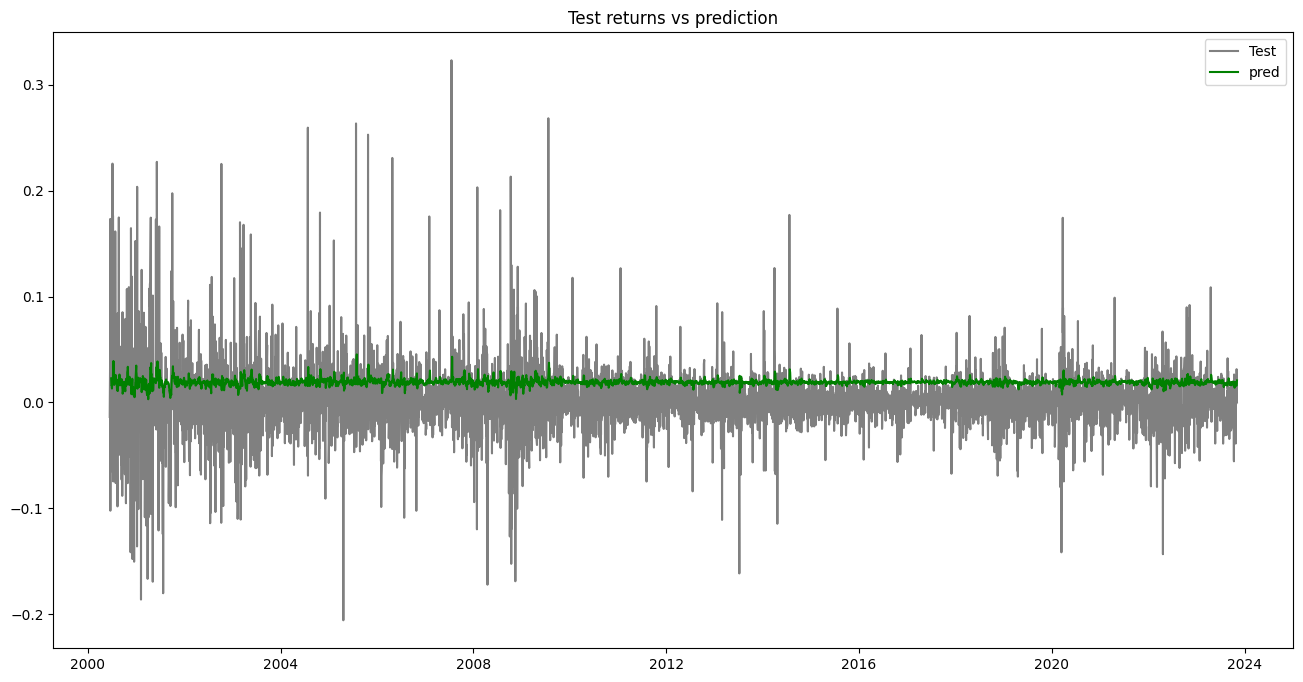

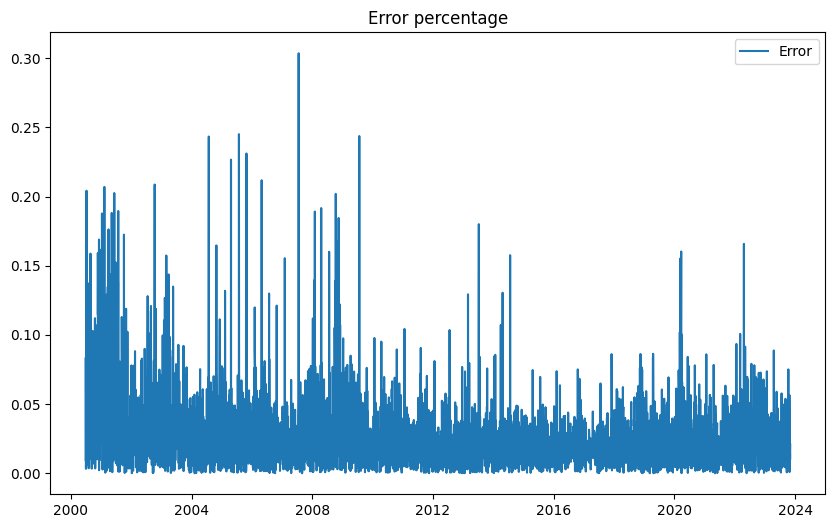

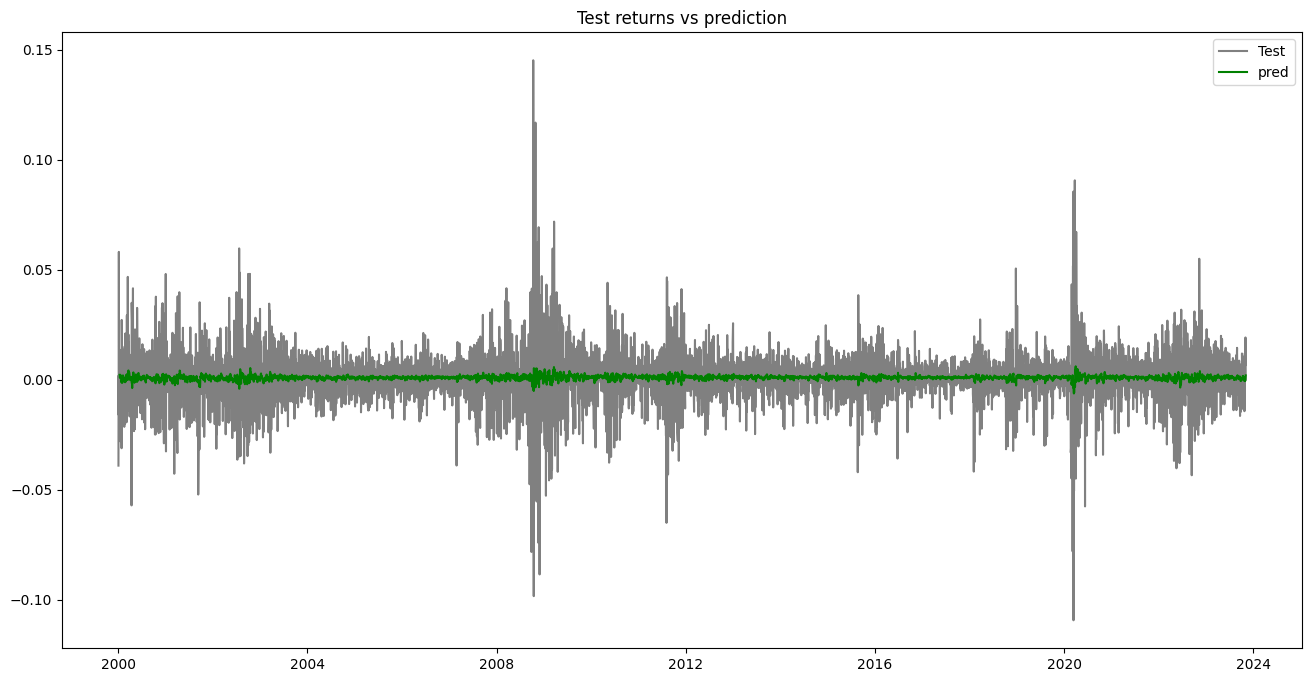

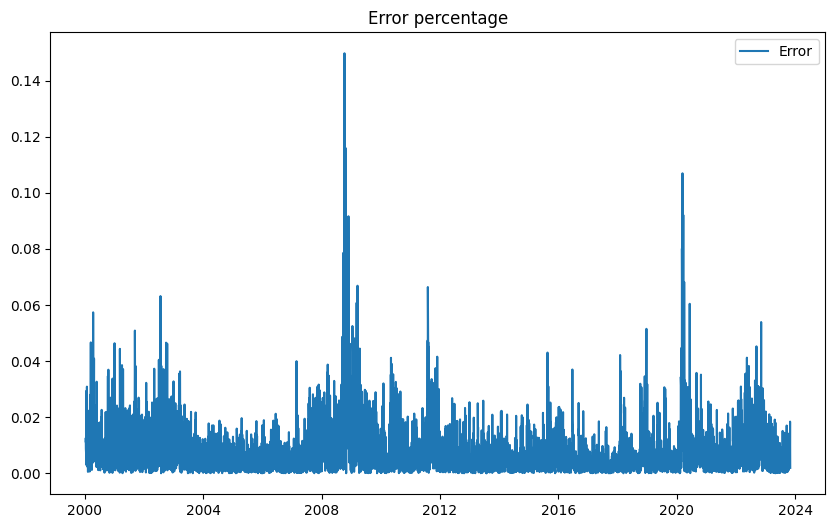

In [80]:
for df_with_prediction in predictions:
    y_test = df_with_prediction['Target']
    y_pred = df_with_prediction['next_day_prediction']
    plt.figure(figsize=(16,8))
    plt.plot(y_test, color = 'grey', label = 'Test')
    plt.plot(y_pred, color = 'green', label = 'pred')
    plt.title('Test returns vs prediction')
    plt.legend()
    plt.show()

        # Calculate error between percentage differences
    df_with_prediction['error'] = abs(y_test - y_pred)

    # Plotting
    plt.figure(figsize=(10, 6))
    # plt.plot(df_with_prediction['pct_diff_SPY_ytest'], label='Percentage Difference SPY_ytest')
    # plt.plot(df_with_prediction['pct_diff_y_pred'], label='Percentage Difference y_pred')
    plt.plot(df_with_prediction['error'], label='Error')
    plt.title('Error percentage')
    plt.legend()
    plt.show()

In [81]:
df_with_prediction

,Open,High,Low,Close,Adj Close,Volume,proportional_variation_compared_to_previous_day,proportional_variation_compared_to_start,Target,next_day_prediction,error
Date,,,,,,,,,,,
2000-01-03,148.250000,148.250000,143.875000,145.437500,94.262581,8164300,0.000000,0.000000,-0.039106,NaN,NaN
2000-01-04,143.531250,144.062500,139.640625,139.750000,90.576317,8089800,-0.039106,-0.039106,0.001789,NaN,NaN
2000-01-05,139.937500,141.531250,137.250000,140.000000,90.738350,12177900,0.001789,-0.037387,-0.016071,NaN,NaN
2000-01-06,139.625000,141.500000,137.750000,137.750000,89.280052,6227200,-0.016071,-0.052858,0.058076,NaN,NaN
2000-01-07,140.312500,145.750000,140.062500,145.750000,94.465103,8066500,0.058076,0.002148,0.003431,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-30,413.559998,416.679993,412.220001,415.589996,415.589996,86562700,0.011956,3.408854,0.006280,-0.000600,0.006881
2023-10-31,416.179993,418.529999,414.209991,418.200012,418.200012,79665200,0.006280,3.436543,0.010665,-0.000337,0.011002
2023-11-01,419.200012,423.500000,418.649994,422.660004,422.660004,98068100,0.010665,3.483858,0.019164,0.000751,0.018413


## Trying decision trees

In [82]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error
# import math
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_squared_error
# from joblib import load

# # Scaler for data normalization
# sc = MinMaxScaler(feature_range=(0,1))

# def refit_data_for_ml(df, backcandles):
#     # Drop specified columns, fill missing values, reset index
#     df = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'proportional_variation_compared_to_start'], axis=1).fillna(0).reset_index(drop=True)
#     df = sc.fit_transform(df)

#     # Generate sequences
#     X = []
#     y = []
#     for i in range(backcandles, len(df)):
#         X.append(df[i-backcandles:i, :-1].flatten())
#         y.append(df[i, -1])

#     # Convert to numpy arrays
#     X, y = np.array(X), np.array(y)
#     return X, y, sc


# def save_model(model, filename_suffix):
#     model_path = f'./model_save/TREE_model_{filename_suffix}.h5'
#     # Save the model
#     from joblib import dump
#     dump(model, model_path)

# def train_decision_tree(X_train, y_train, max_depth=None, min_samples_split=2, ccp_alpha=0.0):
#     # Create and train the decision tree model with regularization parameters
#     model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, ccp_alpha=ccp_alpha)
#     model.fit(X_train, y_train)
#     return model
    
# def tree_train_pipeline(dfs, backcandles, max_depth=50, min_samples_split=2, ccp_alpha=0.0):
#     combined_df = pd.concat(dfs, ignore_index=True)
#     X, y, scaler = refit_data_for_ml(combined_df, backcandles)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     # If max_depth is None, train a single model without iterating over depths
#     if max_depth is None:
#       pass 

#     # If max_depth is not None, iterate over a range of depths to find the best model
#     best_score = float('inf')
#     best_model = None
#     for depth in range(1, max_depth+1):
#         model = train_decision_tree(X_train, y_train, max_depth=depth, min_samples_split=min_samples_split, ccp_alpha=ccp_alpha)
#         scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
#         mean_score = -scores.mean()
#         if mean_score < best_score:
#             best_score = mean_score
#             best_model = model

#     # Train the final model with the best depth found
#     final_model = train_decision_tree(X_train, y_train, max_depth=best_model.get_depth(), min_samples_split=min_samples_split, ccp_alpha=ccp_alpha)

#     # Calculate training and test errors
#     y_train_pred = final_model.predict(X_train)
#     train_error = mean_squared_error(y_train, y_train_pred)
#     y_test_pred = final_model.predict(X_test)
#     test_error = mean_squared_error(y_test, y_test_pred)

#     # Save the model with a filename suffix based on test error
#     save_model(final_model, f'loss{test_error:.4f}')

#     return final_model, scaler

# def tree_predict_pipeline(dfs, model, backcandles):
#     for df in dfs:
#         X,y, scaler = refit_data_for_ml(df, backcandles)

#         # Prepare data for prediction
#         X = []
#         for i in range(backcandles, len(df)):
#             X.append(df.iloc[i-backcandles:i, :-1].values.flatten())

#         X = np.array(X)

#         # Generate predictions
#         y_pred = model.predict(X)

#         # Rescale predictions
#         expanded_pred = np.zeros((y_pred.shape[0], len(scaler.scale_)))
#         expanded_pred[:, -1] = y_pred
#         y_pred_rescaled = scaler.inverse_transform(expanded_pred)[:, -1]

#         # Handle the discrepancy in lengths
#         padding = np.full((backcandles,), np.nan)
#         full_predictions = np.concatenate([padding, y_pred_rescaled])

#         # Append the predictions as a new column
#         df['next_day_prediction'] = full_predictions

#     return dfs


In [83]:
# TREEmodel, scaler = tree_train_pipeline([SPY_df], 7)
# TREEmodel = load('./model_save/TREE_model_loss0.0031.h5')

In [84]:
# predictions = tree_predict_pipeline([ISRG_df, SPY_df], TREEmodel,7)

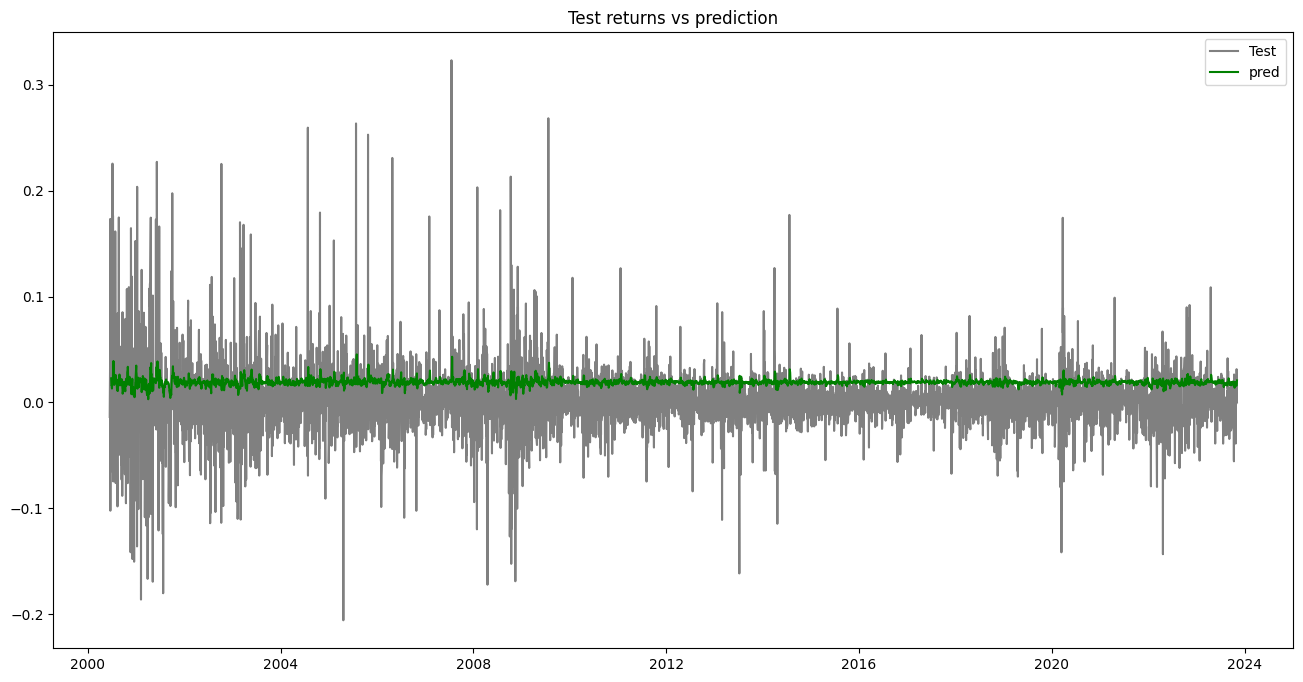

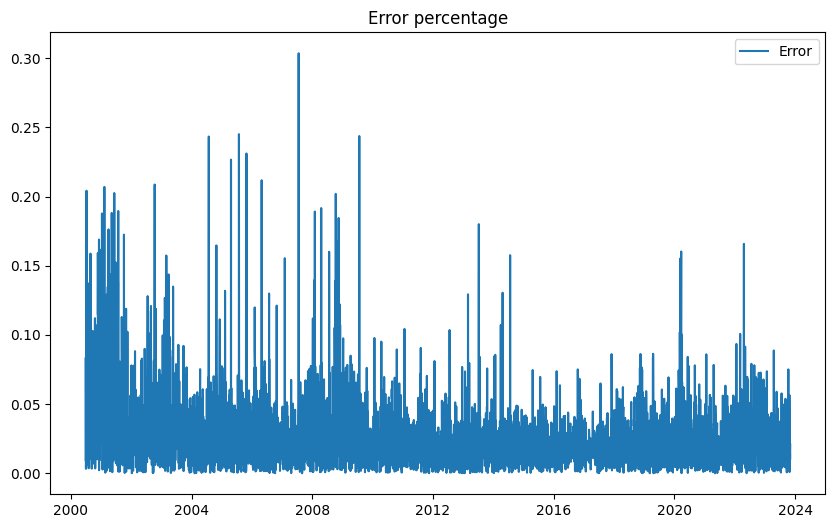

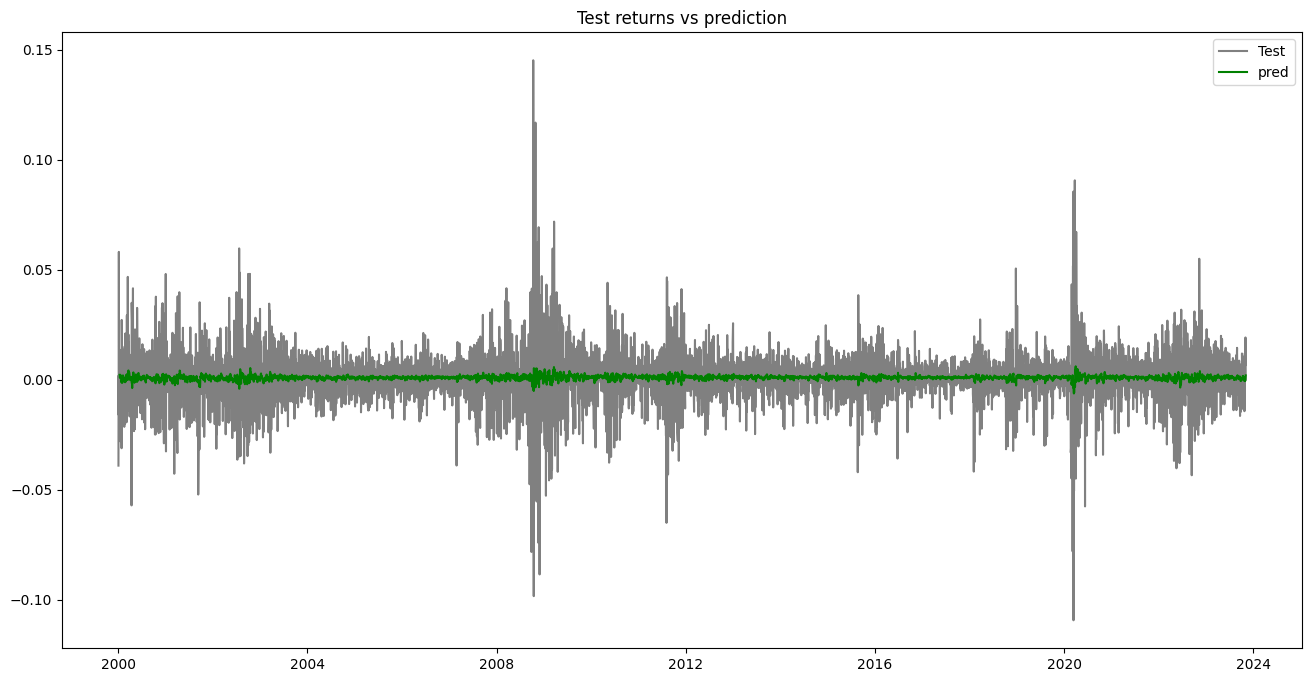

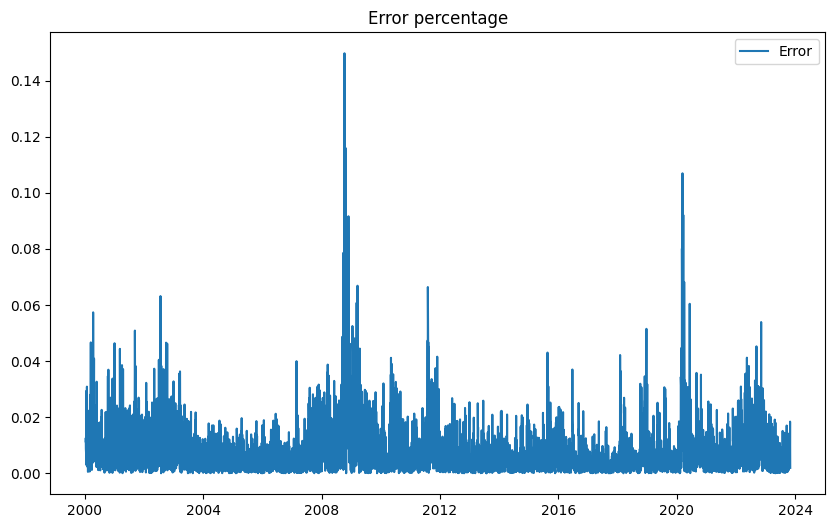

In [85]:
for df_with_prediction in predictions:
    y_test = df_with_prediction['Target']
    y_pred = df_with_prediction['next_day_prediction']
    plt.figure(figsize=(16,8))
    plt.plot(y_test, color = 'grey', label = 'Test')
    plt.plot(y_pred, color = 'green', label = 'pred')
    plt.title('Test returns vs prediction')
    plt.legend()
    plt.show()

        # Calculate error between percentage differences
    df_with_prediction['error'] = abs(y_test - y_pred)

    # Plotting
    plt.figure(figsize=(10, 6))
    # plt.plot(df_with_prediction['pct_diff_SPY_ytest'], label='Percentage Difference SPY_ytest')
    # plt.plot(df_with_prediction['pct_diff_y_pred'], label='Percentage Difference y_pred')
    plt.plot(df_with_prediction['error'], label='Error')
    plt.title('Error percentage')
    plt.legend()
    plt.show()